In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn import datasets
iris = datasets.load_iris()

In [6]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [10]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [14]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [90]:
iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width,target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [24]:
iris_cols = iris_df.columns.to_list()
renamed_cols = [c.replace('(cm)','').strip().replace(' ','_') for c in iris_cols]
print(renamed_cols)

iris_df.rename(columns = dict(zip(iris_cols, renamed_cols)), inplace=True)

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']


In [25]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


<Axes: xlabel='petal_width', ylabel='Density'>

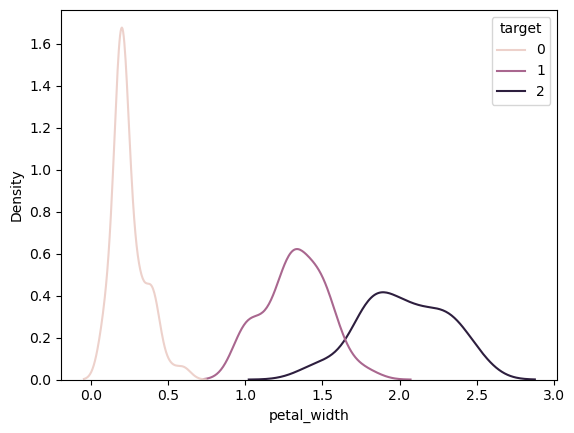

In [103]:
col = iris_df.columns.to_list()[3]
sns.kdeplot(iris_df, x=col, hue='target')

In [34]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, matthews_corrcoef, roc_auc_score

In [31]:
X_train, X_test, y_train, y_test = train_test_split(iris_df.drop('target', axis=1), iris_df.target, test_size=0.33, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(100, 4) (100,)
(50, 4) (50,)


In [32]:
iris_df.target.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [33]:
y_train.value_counts()

target
1    35
2    34
0    31
Name: count, dtype: int64

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline


## Create first pipeline for base without reducing features
pipe = Pipeline(steps=[('clf', SVC())])

## Stratified K folds
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

## Scoring Metric
#scoring_metric = 'accuracy'
scoring_metric = 'matthews_corrcoef'


## Hyper parameter grid
param_grid = [
    {
        'clf':[RandomForestClassifier(random_state=123)],
        'clf__n_estimators':[10,50, 100, 150, 200, 300],
        'clf__max_depth':[2,5,7,13],
    },
    {
        'clf':[SVC()],
        'clf__C':[0.1,1,10],
        'clf__kernel':['linear', 'rbf']
    },
    {
        'clf':[LogisticRegression()],
        'clf__penalty':['l1','l2'],
        'clf__C':np.logspace(-3.5,4.5,20),
        'clf__solver':['liblinear']
    },
    {
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':np.arange(2,20,1)
    }
]

## Grid Search Object
grid = GridSearchCV(estimator = pipe, param_grid=param_grid, cv=cv, scoring=scoring_metric, n_jobs=-1, verbose=True)


In [67]:
from datetime import datetime
import time

labels = [0,1,2]

start = datetime.now()
print('Tuning started at ', start.time())
clf = grid.fit(X_train, y_train)

## Fit on data
best_clf = clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
print('Best classifier MCC score', matthews_corrcoef(y_test, y_pred))

end = datetime.now()
print('Tuning ended at ', end.time())
print('Time taken in fine tuning models is', (end-start))

Tuning started at  09:05:19.331931
Fitting 5 folds for each of 88 candidates, totalling 440 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaco

Fitting 5 folds for each of 88 candidates, totalling 440 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ec2-user/anaco

Best classifier MCC score 0.9704463208685162
Tuning ended at  09:05:46.987296
Time taken in fine tuning models is 0:00:27.655365


In [73]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

Pipeline(steps=[('clf',
                 LogisticRegression(C=13.538761800225446, solver='liblinear'))])
{'clf': LogisticRegression(), 'clf__C': 13.538761800225446, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
0.9569850978076232


In [83]:
best_model = grid.best_estimator_['clf']

Val set Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.94      1.00      0.97        15
           2       1.00      0.94      0.97        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

MCC Score on the entire Validation set is 0.9704463208685162
Individual MCC Score is:
MCC Score on target label 0 is 1.0
MCC Score on target label 1 is 0.9543135154205278
MCC Score on target label 2 is 0.9543135154205278


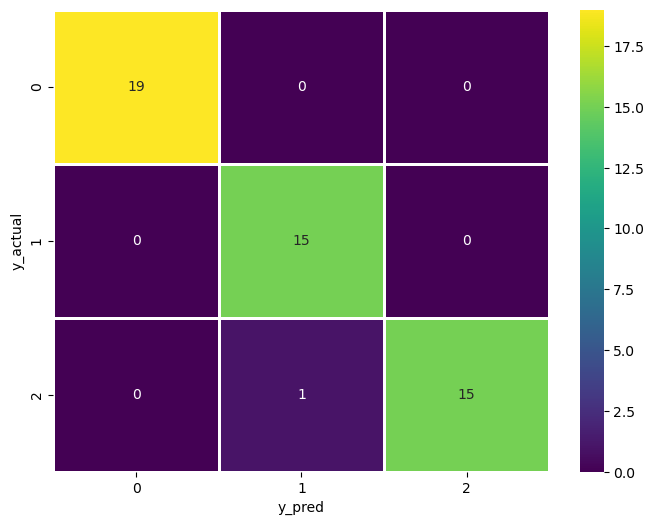

In [84]:
from sklearn.metrics import confusion_matrix
### Print Eval metrics
y_pred = best_model.predict(X_test)

print('Val set Results')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
ax = sns.heatmap(data=cm, cmap='viridis', annot=True, linewidths=1)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_actual')

print('MCC Score on the entire Validation set is', matthews_corrcoef(y_test, y_pred))
print('Individual MCC Score is:')

for i in labels:
    TP = cm[i,i]
    FP = np.sum(cm[:,i])-cm[i,i]
    FN = np.sum(cm[i,:])-cm[i,i]
    TN = np.sum(cm) - (TP+FP+FN)
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    print(f'MCC Score on target label {i} is {MCC}')
    

In [85]:
### Save model and other objects
import pickle as pkl

features = X_train.columns.to_list()
model_name = 'iris_lr_0623'

with open(model_name+'_features.pkl', 'wb') as f:
    pkl.dump(features, f)
    print('Features saved as', model_name+'_features.pkl')

with open(model_name+'_modelObj.pkl', 'wb') as f:
    pkl.dump(best_model, f)
    print('Model saved as', model_name+'_modelObj.pkl')

Features saved as iris_lr_0623_features.pkl
Model saved as iris_lr_0623_modelObj.pkl


In [89]:
## Model Explainability
best_model.coef_

array([[ 0.63867031,  2.24285029, -3.48371541, -1.58346875],
       [-0.03701784, -2.50953447,  1.06580703, -2.31688673],
       [-2.46922102, -3.8570209 ,  4.1792639 ,  5.75371846]])

<Axes: >

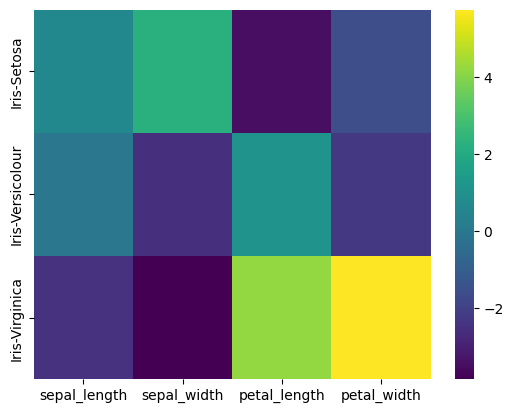

In [95]:
coeff_ = pd.DataFrame(data=best_model.coef_, index=['Iris-Setosa','Iris-Versicolour','Iris-Virginica'], columns=features)

sns.heatmap(coeff_, cmap='viridis')